In [4]:
# Define colors
Pitt.Blue<-"#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray <- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")
options(repr.plot.width=10, repr.plot.height=10/1.68)
pitt.theme<-theme( panel.background = element_rect(fill = "white", linewidth = 0.5, linetype = "solid"),
  panel.grid.major = element_line(linewidth = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = "white")
  )
base<- ggplot() +aes()+ pitt.theme

## Soccer score lines.

In a homework you will build a simulation model of scorelines for soccer.

I'll read in the parameters I gave you here


In [5]:
inTeams<-read.csv('TeamEstim.csv')
head(inTeams)

,team,alpha,delta,XG,XGA
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Arsenal,0.282524652,0.664408836,1.761972,0.6835198
2,Aston Villa,0.127861566,-0.044037071,1.509488,1.3881143
3,Bournemouth,0.009977517,0.023868964,1.341632,1.2969822
4,Brentford,0.055149116,-0.097188167,1.403625,1.4638901
5,Brighton,0.052443727,-0.009484941,1.399833,1.3409712
6,Chelsea,0.264157343,0.011395550,1.729905,1.3132613


Get the mean parameters (and the log mean)

Get just the teams in the Premier League

In [7]:
premTeams<-inTeams$team
rownames(inTeams)<-premTeams
df.prem<-inTeams[,c("alpha","delta")]
df.prem

,alpha,delta
,<dbl>,<dbl>
Arsenal,0.282524652,0.664408836
Aston Villa,0.127861566,-0.044037071
Bournemouth,0.009977517,0.023868964
Brentford,0.055149116,-0.097188167
Brighton,0.052443727,-0.009484941
Chelsea,0.264157343,0.011395550
Crystal Palace,-0.060000848,0.074826942
Everton,-0.327127169,0.159682064
Fulham,-0.045146143,0.065871831


Because the value for $\lambda$ has to be greater than 0, we will use a model where team $i$, when playing team $j$, scores $\lambda_{ij}=\exp(\alpha_i-\delta_j)$ where:
* $\alpha_i$ is an offense parameter for team $i$
* $\delta_j$ is a defense parameter for team $j$

where this will guarantee that the expected goals for/conceded against the average team will match the given `off` and `def` parameters

Set up lists of the parameters:

In [10]:
alphaList<-df.prem$alpha
deltaList<-df.prem$delta
names(alphaList)<-rownames(df.prem)
names(deltaList)<-rownames(df.prem)

Using the `rpois` command we can draw a random possion draw of the scoreline for a particular match. Here we'll try this for *Liverpool* vs. *Manchester City*:

In [12]:
c(rpois(1,exp(alphaList["Liverpool"]-deltaList["Man City"])),
  rpois(1,exp(alphaList["Man City"]-deltaList["Liverpool"])))

[1] 2 1

Generalizing this into a function that takes as arguments the two team names:

In [13]:
draw.score<-function(team1,team2){
    c(
        rpois(1,exp(alphaList[team1]-deltaList[team2])),
  rpois(1,exp(alphaList[team2]-deltaList[team1]))
    )
}
draw.score("Liverpool","Arsenal")

[1] 0 1

We can assemble the set of all matches

In [15]:
#install.packages('gtools')
library('gtools')
# All possible matches in a season
allMatches<-permutations(20, 2, v=rownames(df.prem),repeats.allowed=FALSE)
colnames(allMatches)<-c("home","away")
head(allMatches,9)

home,away
Arsenal,Aston Villa
Arsenal,Bournemouth
Arsenal,Brentford
Arsenal,Brighton
Arsenal,Chelsea
Arsenal,Crystal Palace
Arsenal,Everton
Arsenal,Fulham
Arsenal,Ipswich


*(Again, the fivethirtyeight model is a bit more complicated, and it incorporates the dynamics, for when a match **means** something extra to one team; we will also ignore this, and not try to carry running totals)*

Your assignment will be to form this in to a coherent picture of the outcomes for an entire league season.

In [16]:
# Example scores through the entire season
ScoresMatrix <- matrix(nrow=nrow(allMatches),  ncol=4)
for (ii in 1:nrow(allMatches)  ) {
    
     ScoresMatrix[ii,1:2]=allMatches[ii,]
     ScoresMatrix[ii,3:4]= draw.score(allMatches[ii,"home"],allMatches[ii,"away"] )  
}
colnames(ScoresMatrix)<-c("home.team","away.team","home.score","away.score")
head(ScoresMatrix)

home.team,away.team,home.score,away.score
Arsenal,Aston Villa,2,0
Arsenal,Bournemouth,0,2
Arsenal,Brentford,1,1
Arsenal,Brighton,4,2
Arsenal,Chelsea,1,1
Arsenal,Crystal Palace,2,0


In [17]:
simSeason<-function(alpha,delta,matrixOut=FALSE){
    outTable<-matrix(0,nrow=20,ncol=6)
    rownames(outTable)<- rownames(df.prem)
    colnames(outTable)<- c("Points","Goals.For","Goals.Against","Goal.Diff","random","Ranking") 
    for (ii in 1: nrow(allMatches)) {
        teamH<- allMatches[ii,"home"]
        teamA<- allMatches[ii,"away"]
        goalsH<-rpois(1,exp(alpha[teamH]-delta[teamA]))
        goalsA<-rpois(1,exp(alpha[teamA]-delta[teamH]))
        if (goalsH>goalsA) outTable[teamH,"Points"]<-outTable[teamH,"Points"]+3
        if (goalsH<goalsA) outTable[teamA,"Points"]<-outTable[teamA,"Points"]+3
        if (goalsH==goalsA){
            outTable[teamH,"Points"]<-outTable[teamH,"Points"]+1
            outTable[teamA,"Points"]<-outTable[teamA,"Points"]+1
        }
        outTable[teamH, "Goals.For"] <- outTable[teamH,"Goals.For"] + goalsH
        outTable[teamA, "Goals.For"] <- outTable[teamA,"Goals.For"] + goalsA
        outTable[teamH, "Goals.Against"] <- outTable[teamH,"Goals.Against"] + goalsA
        outTable[teamA, "Goals.Against"] <- outTable[teamA,"Goals.Against"] + goalsH
        }
    # Add tiebreakers
    outTable[  ,"random"]<-runif(20)
    #Create Goal Difference
    outTable[ ,"Goal.Diff"]<-outTable[ ,"Goals.For"]-outTable[,"Goals.Against"]
    # Order it and assign ranking
    outTable[ order( -outTable[ , "Points"] , - outTable[ , "Goal.Diff"], -outTable[ , "Goals.For"],  -outTable[ , "random"]),  "Ranking"] <- 1:20
    if (matrixOut) {
        return(outTable[order( -outTable[ , "Points"] , - outTable[ , "Goal.Diff"], -outTable[ , "Goals.For"], -outTable[ , "random"]), c("Ranking","Points","Goal.Diff","Goals.For")])
    }
    else{
        return(outTable[ ,"Ranking"])
    }
    
}
simSeason(alphaList,deltaList)

Arsenal    Aston Villa    Bournemouth      Brentford       Brighton 
             2             11             10             13              7 
       Chelsea Crystal Palace        Everton         Fulham        Ipswich 
            12             14              9              8             18 
     Leicester      Liverpool       Man City     Man United      Newcastle 
            19              3              1              6              5 
 Nott'm Forest    Southampton      Tottenham       West Ham         Wolves 
            15             20              4             17             16

In [18]:
monte.carlo.sim<-function(fun,fun.arg,nSims=10000){
    # this line just runs fun(arguments in fun.arg list) so if fun.arg=(x,y,z) do.call(fun,fun.arg) runs fun(x,y,z)
    rep1<- do.call(fun,fun.arg) 
    # Set the dimensions for the output matrix
    nc<-length(rep1)
    lbl<-names(rep1)
    outputMatrix <- matrix(1,nrow=nSims, ncol=nc)
    outputMatrix[1, ]<-rep1 # write the sim to the first line
    for (rep in 2:nSims) { # for each of the remaining sims, add them in
        outputMatrix[rep, ] <- do.call(fun,fun.arg)
    }
    df<-data.frame(outputMatrix) # convert it to a data frame
    names(df)<-lbl  # get the names from the simulation output lbl
    return(df) # return the data frame as the output
}

In [19]:
ptm <- proc.time()
simdf.Base <- monte.carlo.sim(simSeason,fun.arg=list(alpha=alphaList,delta=deltaList,matrix=FALSE),nSims=50000)
proc.time() - ptm

   user  system elapsed 
192.090   0.013 192.568 

Use the `reshape2` library to put this into a nicer format for the graph I want to draw

In [24]:
#save(simdf.Base,file="MainSim.rda")
library(tidyr)
flat.df <- setNames(gather(simdf.Base),c("team","Rank"))

## Question 1
Here I use a box plot to illustrate the variation by team. It's a little boring, but I think is useful as an infographic.

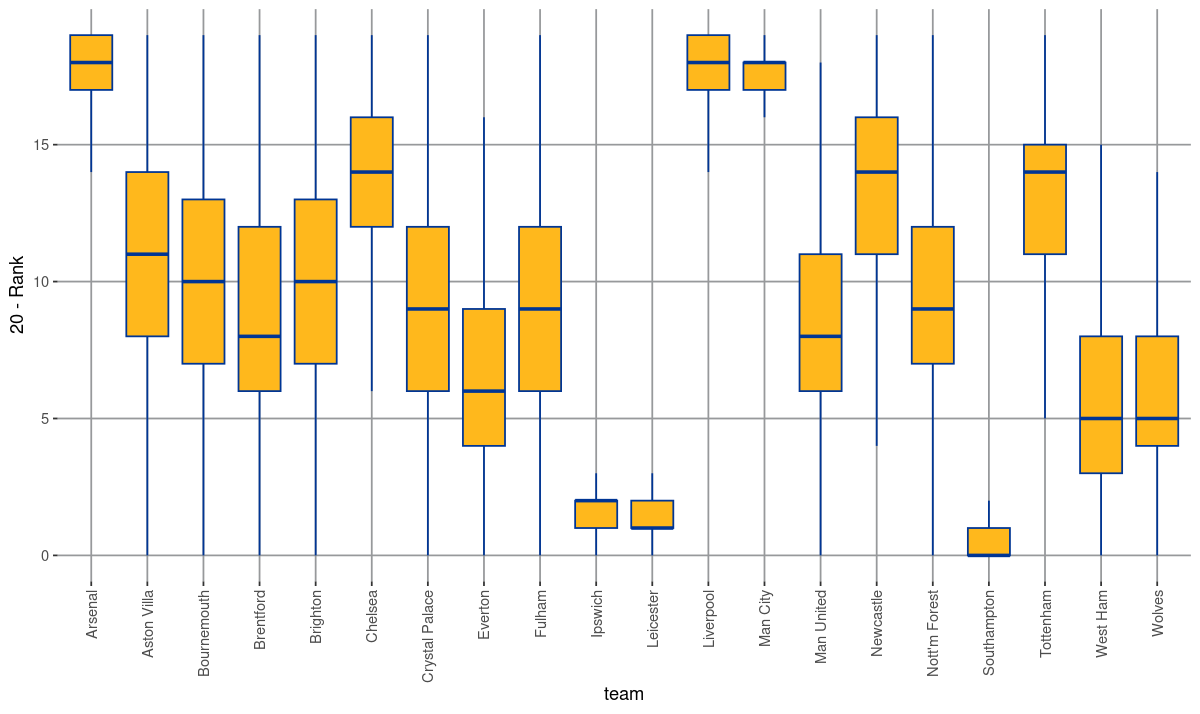

In [26]:
ggplot(flat.df, aes(team, 20-Rank)) + 
geom_boxplot(fill =Pitt.Gold, colour = Pitt.Blue,outlier.alpha=0)+pitt.theme+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [27]:
PayoffVector=c(+149.6,
+145.9,
+142.1,
+138.4,
+73.7,
+70.0,
+55.2,
+33.5,
+29.8,
+26.0,
+22.3,
+18.6,
+14.9,
+11.2,
+7.5,
+3.7,
+0,
-88.7,
-92.5,
-96.2)

## Question 2
Here I again use a box plot, but where I switch to the payoffs to illustrate things

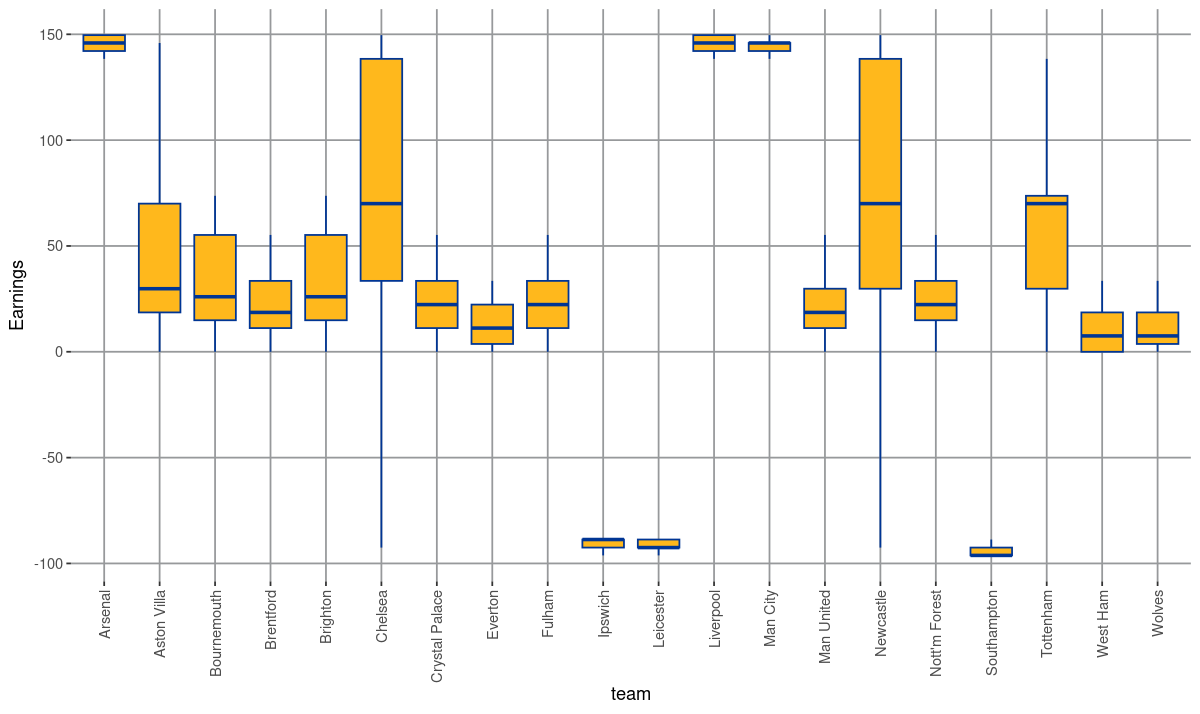

In [28]:
flat.df["Earnings"]<-PayoffVector[flat.df$Rank]
ggplot(flat.df, aes(team, Earnings)) + 
geom_boxplot(fill =Pitt.Gold, colour = Pitt.Blue,outlier.alpha=0)+pitt.theme+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [33]:
RankProbMatrix<-matrix(0,nrow=20,ncol=20)
    rownames(RankProbMatrix)<-rownames(df.prem)
    colnames(RankProbMatrix)<-c(1:20)
    for (team in rownames(df.prem)){
        for (ii in 1:20) {
            RankProbMatrix[team, ii] <-  sum( ifelse( simdf.Base[ ,team]==ii,1,0)  )/nrow(simdf.Base)
        }
    }

In [47]:
RankProbMatrix.df<- as.data.frame(RankProbMatrix)
RankProbMatrix.df$team<-rownames(df.prem)

In [53]:
RankProbMatrix.df

,1,2,3,4,5,6,7,8,9,10,⋯,12,13,14,15,16,17,18,19,20,team
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Arsenal,0.34536,0.31036,0.22012,0.07436,0.02756,0.01170,0.00512,0.00252,0.00178,0.00036,⋯,0.00014,0.00010,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Arsenal
Aston Villa,0.00118,0.00568,0.01916,0.05680,0.07888,0.09314,0.09576,0.09234,0.09170,0.08428,⋯,0.07324,0.06338,0.05520,0.04690,0.03558,0.02176,0.00524,0.00066,0.00006,Aston Villa
Bournemouth,0.00048,0.00334,0.01198,0.03622,0.05460,0.07046,0.07808,0.08470,0.08672,0.08602,⋯,0.08350,0.08090,0.07424,0.06338,0.05144,0.03578,0.00832,0.00144,0.00008,Bournemouth
Brentford,0.00034,0.00146,0.00636,0.02302,0.03796,0.04996,0.06106,0.07098,0.07692,0.08174,⋯,0.08738,0.08914,0.09040,0.08416,0.07714,0.05756,0.01500,0.00298,0.00024,Brentford
Brighton,0.00058,0.00274,0.01240,0.04030,0.06110,0.07440,0.07962,0.08502,0.08916,0.09000,⋯,0.08172,0.07538,0.07026,0.06026,0.04906,0.03300,0.00752,0.00126,0.00006,Brighton
Chelsea,0.01038,0.03334,0.08396,0.17324,0.15688,0.12646,0.09846,0.07866,0.05974,0.04960,⋯,0.03124,0.02162,0.01618,0.01124,0.00646,0.00336,0.00056,0.00002,0.00000,Chelsea
Crystal Palace,0.00038,0.00198,0.00988,0.02954,0.04860,0.06232,0.07408,0.08032,0.08252,0.08806,⋯,0.08758,0.08566,0.07840,0.07034,0.05736,0.04188,0.00986,0.00182,0.00016,Crystal Palace
Everton,0.00004,0.00016,0.00140,0.00542,0.01272,0.01854,0.02706,0.03728,0.04672,0.05684,⋯,0.08084,0.09626,0.11014,0.12836,0.13638,0.12548,0.03852,0.00896,0.00118,Everton
Fulham,0.00038,0.00270,0.00958,0.03126,0.05000,0.06532,0.07564,0.08064,0.08598,0.08562,⋯,0.08726,0.08168,0.07802,0.07024,0.05792,0.03916,0.01000,0.00138,0.00020,Fulham


In [54]:
df.Rank <- gather(RankProbMatrix.df, key = "rank", value = "freq", -team)
df.Rank$rank <- as.integer(df.Rank$rank)

In [55]:
head(df.Rank)

,team,rank,freq
,<chr>,<int>,<dbl>
1,Arsenal,1,0.34536
2,Aston Villa,1,0.00118
3,Bournemouth,1,0.00048
4,Brentford,1,0.00034
5,Brighton,1,0.00058
6,Chelsea,1,0.01038


I also tried making a tile plot, but didn't really get it to the point that I was happy with it.

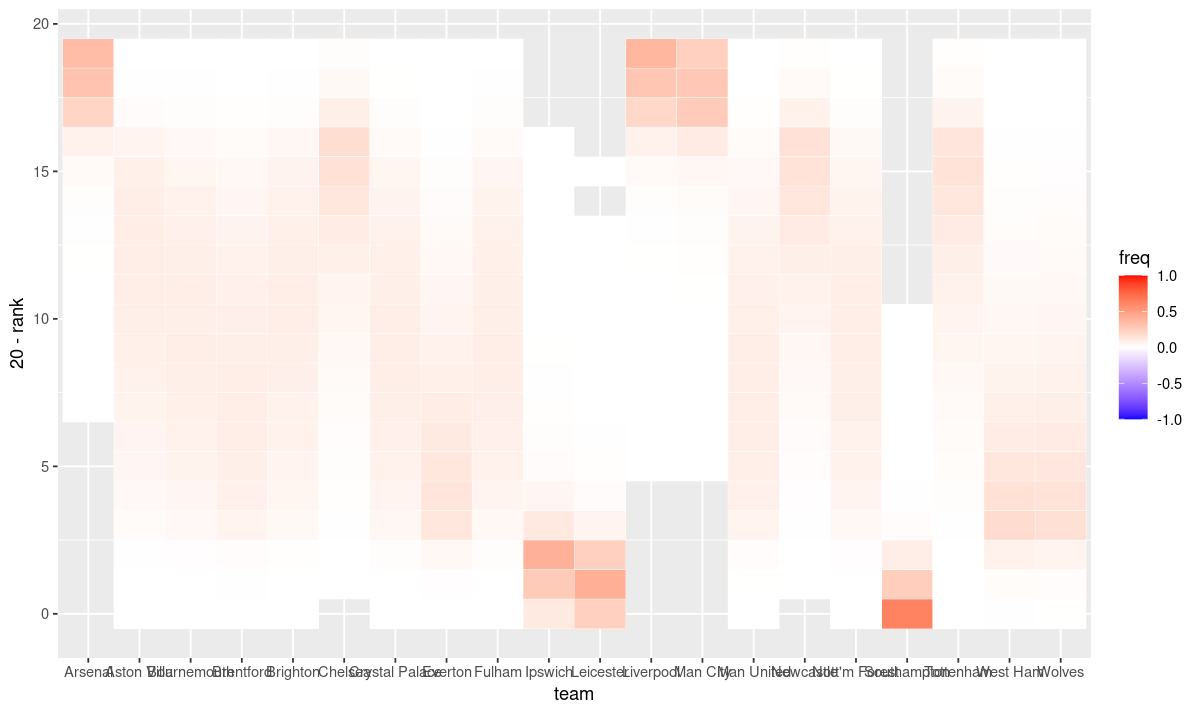

In [56]:
ggplot(data = subset(df.Rank,freq>0), aes(x=team, y=20-rank, fill=freq)) + geom_tile(color = "white")+
scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab")

This function creates the final output:

In [57]:
CalculateStats<-function (simdf) {
    RankProbMatrix<-matrix(0,nrow=20,ncol=20)
    rownames(RankProbMatrix)<-rownames(df.prem)
    for (team in rownames(df.prem)){
        for (ii in 1:20) {
            RankProbMatrix[team, ii] <-  sum( ifelse( simdf[ ,team]==ii,1,0)  )/nrow(simdf)
        }
    }
    outStats<-data.frame( "Mean.Earn"=RankProbMatrix %*% PayoffVector)
    outStats["SD.Earn"] <- 0
    outStats["Min.Earn"] <- 0
    outStats["Max.Earn"] <- 0
    outStats["CL.Earn"] <-0
    outStats["CU.Earn"] <-0
    outStats["Mean.Pos"] <- 0
    outStats["SD.Pos"] <- 0
    outStats["Min.Pos"] <- 0
    outStats["Max.Pos"] <- 0
    for  (team in rownames(df.prem)) {
        team_data<-simdf[ ,team]
        team_payoff<-PayoffVector[simdf[ ,team]]
        outStats[team,"Mean.Pos"] <- mean(team_data)
        outStats[team,"SD.Pos"] <- sd(team_data)
        outStats[team,"Max.Pos"] <- min(team_data)
        outStats[team,"Min.Pos"] <- max(team_data)
        outStats[team,"SD.Earn"] <- sd( team_payoff )
        outStats[team,"Max.Earn"]<- max(team_payoff )
        outStats[team,"Min.Earn"] <- min(team_payoff )
        outStats[team,"CL.Earn"] <- quantile(team_payoff  , 0.025 )
        outStats[team,"CU.Earn"] <-quantile(team_payoff  ,  0.975 )
    }
    return(outStats)
}
OutputDF<-CalculateStats(simdf.Base)
OutputDF["Lucky.Earn"] <- 0

In [58]:
simSeasonLucky<-function(teamLuck,alpha,delta,matrixOut=FALSE){
    outTable<-matrix(0,nrow=20,ncol=6)
    rownames(outTable)<- rownames(df.prem)
    colnames(outTable)<- c("Points","Goals.For","Goals.Against","Goal.Diff","random","Ranking") 
    outTable[teamLuck,"Points"] <- 3 # Add 3 points to the lucky team
    outTable[teamLuck,"Goals.For"] <- 2 #Add 2 goals (as if taking a 1-0 loss to a win)
    for (ii in 1: nrow(allMatches)) {
        teamH<- allMatches[ii,"home"]
        teamA<- allMatches[ii,"away"]
        goalsH<-rpois(1,exp(alpha[teamH]-delta[teamA]))
        goalsA<-rpois(1,exp(alpha[teamA]-delta[teamH]))
        if (goalsH>goalsA) outTable[teamH,"Points"]<-outTable[teamH,"Points"]+3
        if (goalsH<goalsA) outTable[teamA,"Points"]<-outTable[teamA,"Points"]+3
        if (goalsH==goalsA){
            outTable[teamH,"Points"]<-outTable[teamH,"Points"]+1
            outTable[teamA,"Points"]<-outTable[teamA,"Points"]+1
        }
        outTable[teamH, "Goals.For"] <- outTable[teamH,"Goals.For"] + goalsH
        outTable[teamA, "Goals.For"] <- outTable[teamA,"Goals.For"] + goalsA
        outTable[teamH, "Goals.Against"] <- outTable[teamH,"Goals.Against"] + goalsA
        outTable[teamA, "Goals.Against"] <- outTable[teamA,"Goals.Against"] + goalsH
        }
    # Add tiebreakers
    outTable[  ,"random"]<-runif(20)
    #Create Goal Difference
    outTable[ ,"Goal.Diff"]<-outTable[ ,"Goals.For"]-outTable[,"Goals.Against"]
    # Order it and assign ranking
    outTable[ order( -outTable[ , "Points"] , - outTable[ , "Goal.Diff"], -outTable[ , "Goals.For"],  -outTable[ , "random"]),  "Ranking"] <- 1:20
    if (matrixOut) {
        return(outTable[order( -outTable[ , "Points"] , - outTable[ , "Goal.Diff"], -outTable[ , "Goals.For"], -outTable[ , "random"]), c("Ranking","Points","Goal.Diff","Goals.For")])
    }
    else{
        return(outTable[ teamLuck,"Ranking"])
    }
}

Generate the Lucky Win Amounts!

In [59]:
for (team in rownames(df.prem)){ # for each team
    # simulate that team getting three extra points
    ListX<- monte.carlo.sim(simSeasonLucky,fun.arg=list(teamLuck=team,alpha=alphaList,delta=deltaList,matrix=FALSE),nSims=2500)
    ValX <- mean(PayoffVector[ ListX[ , 1]  ] )
    OutputDF[ team,"Lucky.Earn"] <-  ValX
}
OutputDF["D.Lucky"] <- OutputDF["Lucky.Earn"]-OutputDF["Mean.Earn"]

Code for changing the parameters:

In [61]:
library(rootSolve)
otherTeams <- setdiff(premTeams,'Liverpool')
alpha <- df.prem['Liverpool','alpha']
otherTeams
alpha

[1] "Arsenal"        "Aston Villa"    "Bournemouth"    "Brentford"     
 [5] "Brighton"       "Chelsea"        "Crystal Palace" "Everton"       
 [9] "Fulham"         "Ipswich"        "Leicester"      "Man City"      
[13] "Man United"     "Newcastle"      "Nott'm Forest"  "Southampton"   
[17] "Tottenham"      "West Ham"       "Wolves"

[1] 0.4485979

In [75]:
alphaList

Arsenal    Aston Villa    Bournemouth      Brentford       Brighton 
   0.282524652    0.127861566    0.009977517    0.055149116    0.052443727 
       Chelsea Crystal Palace        Everton         Fulham        Ipswich 
   0.264157343   -0.060000848   -0.327127169   -0.045146143   -0.410093579 
     Leicester      Liverpool       Man City     Man United      Newcastle 
  -0.507651132    0.448597860    0.425689553   -0.051470621    0.242786527 
 Nott'm Forest    Southampton      Tottenham       West Ham         Wolves 
   0.004658128   -0.704610924    0.277106631   -0.063402066   -0.021450136

In [62]:
alphaShift <- function(team){
    alphaIn <- df.prem[team,"alpha"]
    otherTeams <- setdiff( rownames(df.prem),team)
    fn <-  function(x) mean(exp(x-df.prem[otherTeams ,"delta"]))-1.1*mean(exp(alphaIn-df.prem[otherTeams ,"delta"])) 
    sol <- multiroot(fn, alphaIn,rtol=1e-12,atol=1e-8) # Start At Alpha and solve for the value that increases parameter by 10%
    return(sol$root)
}
deltaShift <- function(team){
    deltaIn <- df.prem[team,"delta"]
    otherTeams <- setdiff( rownames(df.prem),team)
    fn <-  function(x) mean(exp(df.prem[otherTeams ,"alpha"]-x))-0.9*mean(exp(df.prem[otherTeams ,"alpha"]-deltaIn))
    sol <- multiroot(fn, deltaIn,rtol=1e-12,atol=1e-8) # Start At Delta and solve for the value that decreases goals conceded by 10%
    return(sol$root)
}
# Test It on liverpool
c(alphaShift('Liverpool'),deltaShift('Liverpool'),df.prem['Liverpool','alpha'],df.prem['Liverpool','delta'])

[1] 0.5439080 0.4801886 0.4485979 0.3748281

In [64]:
# Could just create these for each team at once
newAlpha <- sapply(rownames(df.prem),alphaShift)
newDelta <- sapply(rownames(df.prem),deltaShift)

These functions run the simulation for each team improvement...

In [65]:
offIncrease <- function(team,nSims=2500){
    alphaV <- df.prem[ , "alpha"]
    names(alphaV) <- rownames(df.prem)
    alphaV[team] <- alphaShift(team)
    delta <- df.prem[ ,"delta"]
    names(delta) <- rownames(df.prem)
    simdf.OffX <- monte.carlo.sim(simSeason,fun.arg=list(alpha=alphaV,delta=delta,matrix=FALSE),nSims=nSims)
    return(CalculateStats(simdf.OffX)[team,"Mean.Earn"])
}
defIncrease <- function(team,nSims=2500) {
    alpha <- df.prem[ , "alpha"]
    names(alpha) <- rownames(df.prem)
    deltaV <- df.prem[ ,"delta"]
    names(deltaV) <- rownames(df.prem)
    deltaV[team] <- deltaShift(team)
    simdf.DefX <- monte.carlo.sim(simSeason,fun.arg=list(alpha=alpha,delta=deltaV,matrix=FALSE),nSims=nSims)
    return(CalculateStats(simdf.DefX)[team,"Mean.Earn"])
}

In [66]:
offIncrease('Liverpool',nSims=50)

[1] 145.326

In [67]:
OutputDF["Inc.Off"]<-0
OutputDF["Inc.Def"]<-0
for (team in rownames(df.prem) ){
    OutputDF[team,"Inc.Off"]<-offIncrease(team,nSims=2500) # Ramp this up to get accurate numbers
    OutputDF[team,"Inc.Def"]<-defIncrease(team,nSims=2500)
}

In [68]:
OutputDF

,Mean.Earn,SD.Earn,Min.Earn,Max.Earn,CL.Earn,CU.Earn,Mean.Pos,SD.Pos,Min.Pos,Max.Pos,Lucky.Earn,D.Lucky,Inc.Off,Inc.Def
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Arsenal,141.813166,17.93083,14.9,149.6,73.7,149.6,2.21620,1.2839979,13,1,145.18916,3.375994,145.35924,144.29576
Aston Villa,41.865224,37.74090,-96.2,149.6,0.0,142.1,9.42364,3.6927012,20,1,53.18448,11.319256,56.40164,55.44744
Bournemouth,33.545114,34.42523,-96.2,149.6,0.0,138.4,10.37388,3.7161284,20,1,44.89144,11.346326,46.10996,44.69308
Brentford,25.989826,32.07202,-96.2,149.6,0.0,138.4,11.33668,3.7074090,20,1,35.20956,9.219734,36.62608,37.12816
Brighton,34.972886,34.87470,-96.2,149.6,0.0,138.4,10.19864,3.7148214,20,1,47.71224,12.739354,49.68212,47.99624
Chelsea,75.880374,46.76204,-92.5,149.6,11.2,145.9,6.56382,3.1712219,19,1,89.05360,13.173226,92.85924,91.98916
Crystal Palace,30.766184,33.02081,-96.2,149.6,0.0,138.4,10.69754,3.6927457,20,1,41.61328,10.847096,42.89504,42.59780
Everton,11.615790,29.36282,-96.2,149.6,-88.7,70.0,13.31358,3.3087016,20,1,20.58716,8.971370,18.85504,20.00580
Fulham,31.422624,33.40896,-96.2,149.6,0.0,138.4,10.62082,3.7079479,20,1,42.45276,11.030136,42.34024,42.02932


Export this to a saved dataframe

In [69]:
save(OutputDF,file="GroupAssignment.Rda")

Create the difference:

In [70]:
OutputDF["D.Lucky"]<-round(OutputDF["Lucky.Earn"]-OutputDF["Mean.Earn"],1)
OutputDF["D.Off"]<-round(OutputDF["Inc.Off"]-OutputDF["Mean.Earn"],1)
OutputDF["D.Def"]<-round(OutputDF["Inc.Def"]-OutputDF["Mean.Earn"],1)
OutputDF

,Mean.Earn,SD.Earn,Min.Earn,Max.Earn,CL.Earn,CU.Earn,Mean.Pos,SD.Pos,Min.Pos,Max.Pos,Lucky.Earn,D.Lucky,Inc.Off,Inc.Def,D.Off,D.Def
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Arsenal,141.813166,17.93083,14.9,149.6,73.7,149.6,2.21620,1.2839979,13,1,145.18916,3.4,145.35924,144.29576,3.5,2.5
Aston Villa,41.865224,37.74090,-96.2,149.6,0.0,142.1,9.42364,3.6927012,20,1,53.18448,11.3,56.40164,55.44744,14.5,13.6
Bournemouth,33.545114,34.42523,-96.2,149.6,0.0,138.4,10.37388,3.7161284,20,1,44.89144,11.3,46.10996,44.69308,12.6,11.1
Brentford,25.989826,32.07202,-96.2,149.6,0.0,138.4,11.33668,3.7074090,20,1,35.20956,9.2,36.62608,37.12816,10.6,11.1
Brighton,34.972886,34.87470,-96.2,149.6,0.0,138.4,10.19864,3.7148214,20,1,47.71224,12.7,49.68212,47.99624,14.7,13.0
Chelsea,75.880374,46.76204,-92.5,149.6,11.2,145.9,6.56382,3.1712219,19,1,89.05360,13.2,92.85924,91.98916,17.0,16.1
Crystal Palace,30.766184,33.02081,-96.2,149.6,0.0,138.4,10.69754,3.6927457,20,1,41.61328,10.8,42.89504,42.59780,12.1,11.8
Everton,11.615790,29.36282,-96.2,149.6,-88.7,70.0,13.31358,3.3087016,20,1,20.58716,9.0,18.85504,20.00580,7.2,8.4
Fulham,31.422624,33.40896,-96.2,149.6,0.0,138.4,10.62082,3.7079479,20,1,42.45276,11.0,42.34024,42.02932,10.9,10.6


## Question 3: What is the value of a lucky win!?

Using the simulation results, I try to illustrate the non-linear pattern to the value of a lucky win.

* On the horizontal axis I plot each team's expected position in the simulation.
* On the vertical axis I plot the value of a lucky win

The figure illustrates the minimal value to a lucky win  to each of Man City and Liverpool (best/second-best) and West Brom (the worst team). The reasoning here is that a single lucky win doesn't really affect these team's final positions by much. 

In contrast, the value of a lucky win for the remaining teams is approximately 8 million GBP, where there are two bumps: 
* teams close to the UCL bubble (positions 1-4)
* teams close to relegation (positions 18-20)




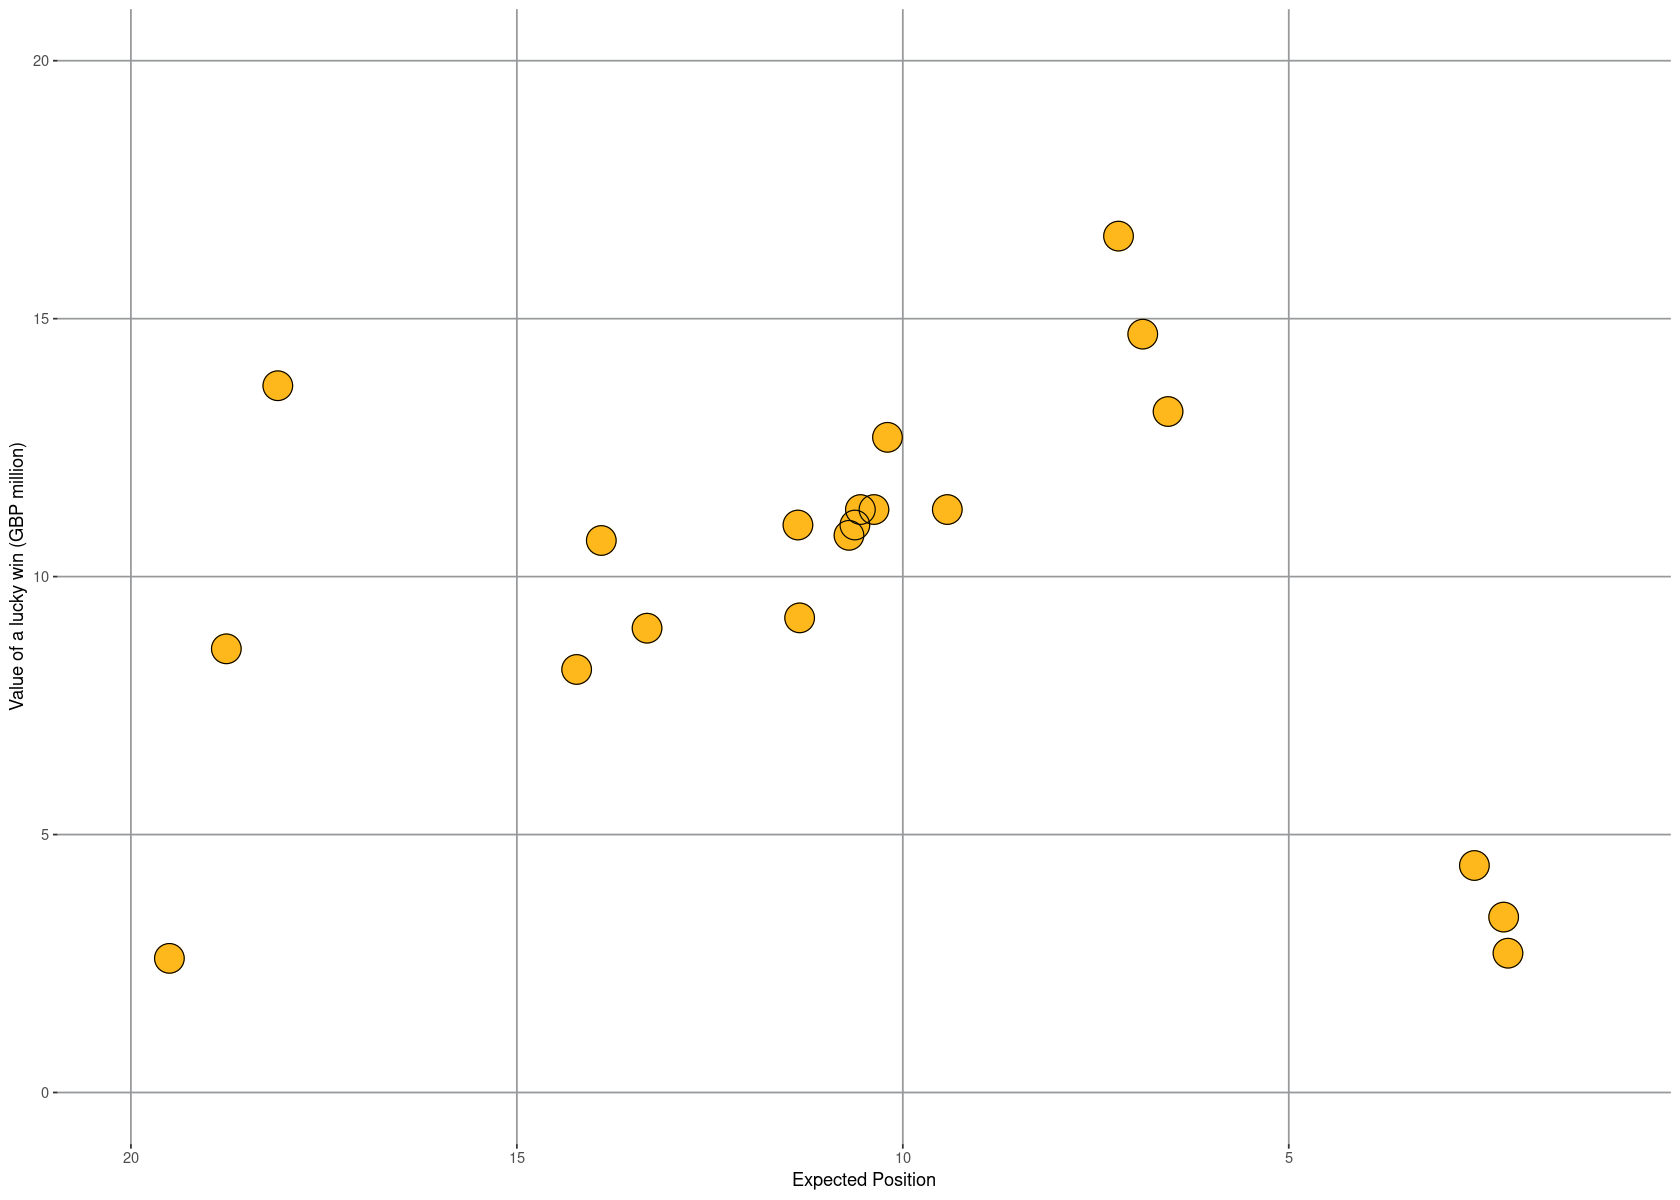

In [73]:
options(repr.plot.width=14, repr.plot.height=10)
ggplot(data=OutputDF, aes( x=Mean.Pos, y=D.Lucky) )+ geom_point(color=Pitt.Gold,size=8)+
geom_point(shape=1,color="black",size=8)+ scale_x_reverse(limits=c(20,1)) +
pitt.theme+ylim(0,20)+
xlab("Expected Position")+ylab("Value of a lucky win (GBP million)")

## Question 4:
Here I illustrate the relationship between the gain from offensive improvement (vertical axis) to the gain from defensive improvement (horizontal axis). Using color, I also demonstrate that the teams who are expected to fall in the bottom half of the table do much better by investing in defense, while the teams expected to come in the top half benefit a bit more from offense investment, but that almost everyone except for Mancheter city would overall prefer to invest in defenders.


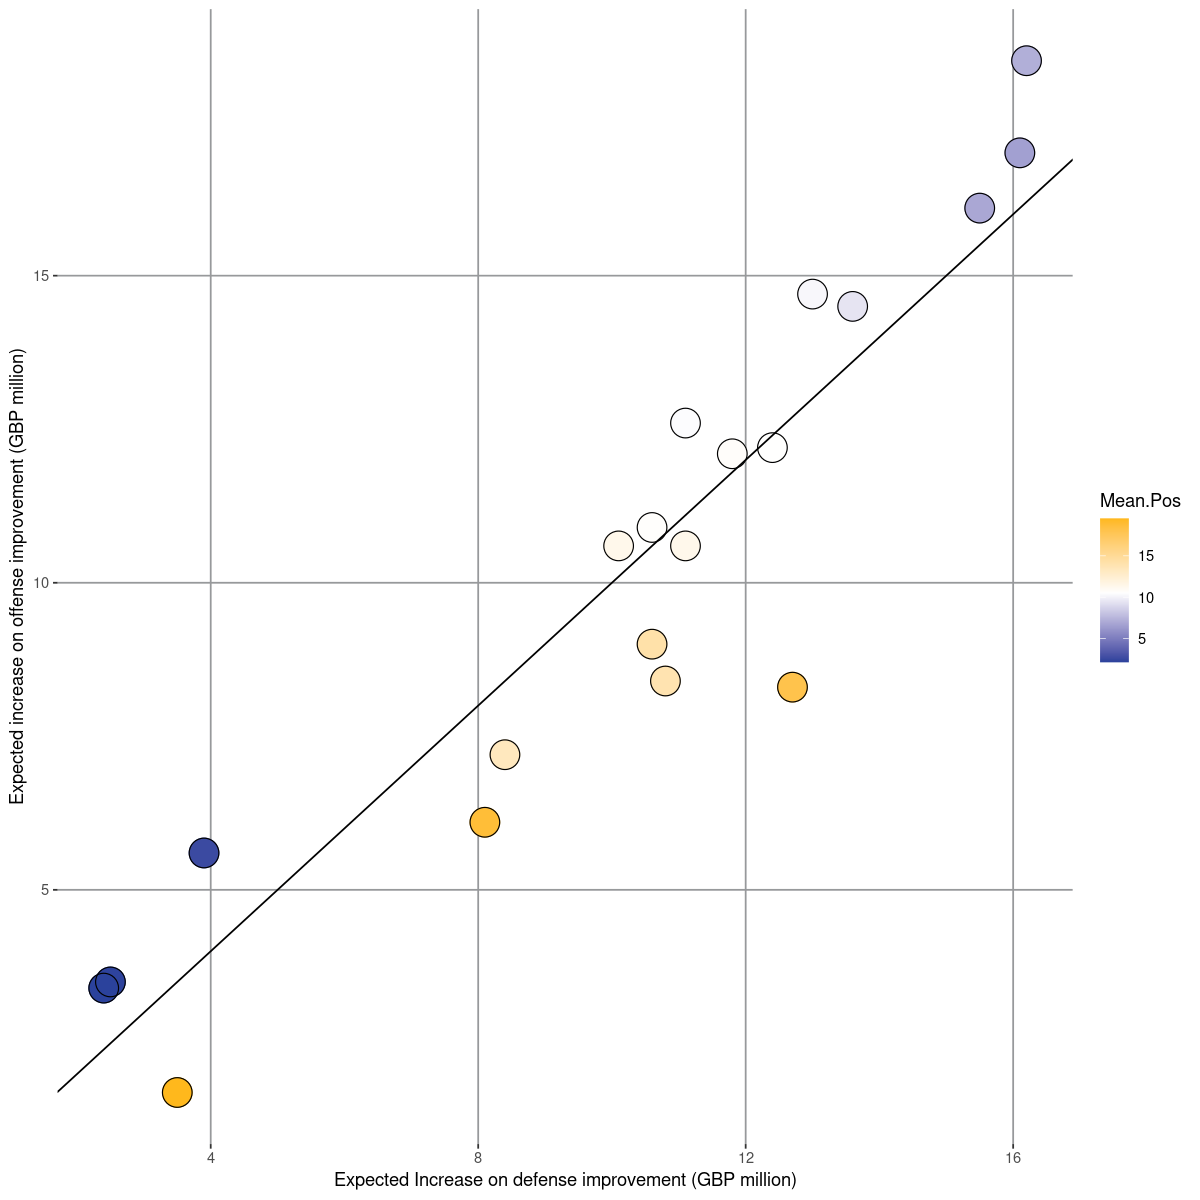

In [74]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=OutputDF, aes(x=D.Def, y=D.Off,label = rownames(OutputDF),color=Mean.Pos) ) +
geom_point(size=8)+ 
geom_point(shape = 1,size = 8,colour = "black")+
pitt.theme+geom_abline(intercept =0,slope=1)+
#geom_text(hjust = 0, nudge_x = 0.3,color="black",angle = -30)+
scale_color_gradient2(midpoint=10.5,low=Pitt.Blue, mid="white",high=Pitt.Gold, space ="Lab")+
xlab("Expected Increase on defense improvement (GBP million)")+ylab("Expected increase on offense improvement (GBP million)")